## File created by Reid Wyde


### Last updated 9.5.19

### TODO


#### short term

add model classes for all growth equations



#### mid term

look at how likelihood is fit/punished (the objective function for pymc3)

add BIC and configure pymc3 for posterior information criterion

visualization on gelman rubin

investigate maximum likelihood parameter sample



#### long term

drug-drug interaction

figure out why nuts fails to initialize

configure theano for multiple cores // windows issue, not possible right now



In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.integrate import odeint



plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline

np.random.seed(123)

In [2]:
## Generalized algorithm



# For each eqn
    # sample priors
    # for each group
        # params_switch(eqn, group)
        # forward(param_switch, eqn, group, priors)
        # likelihood(group, forward)
    #sum(likelihood(groups))



# Data driven growth models for Adjuvant Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth, provided by Dr. Ernesto Lima, The Center for Computational Oncology at The University of Texas, 2019. 

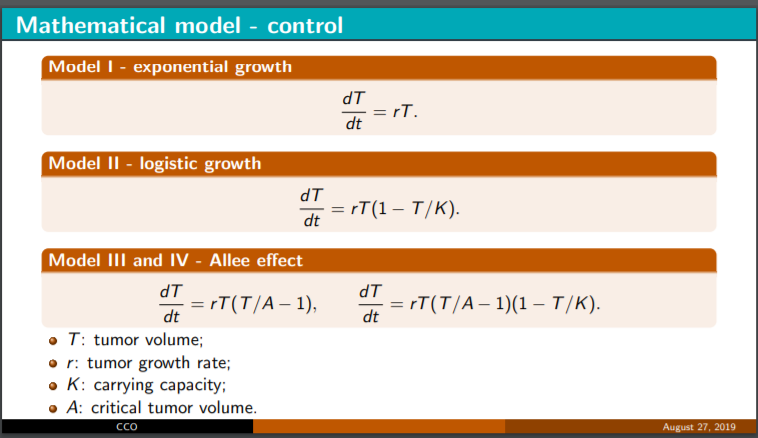

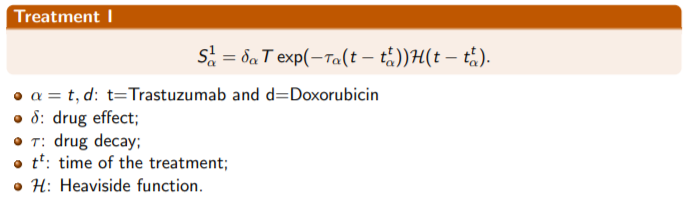

# 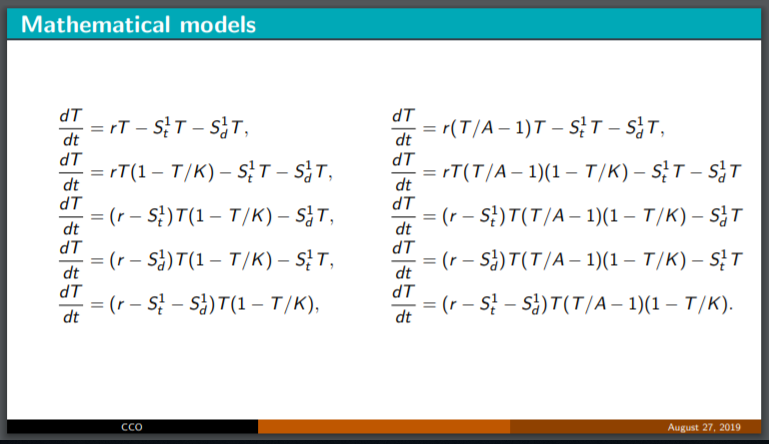

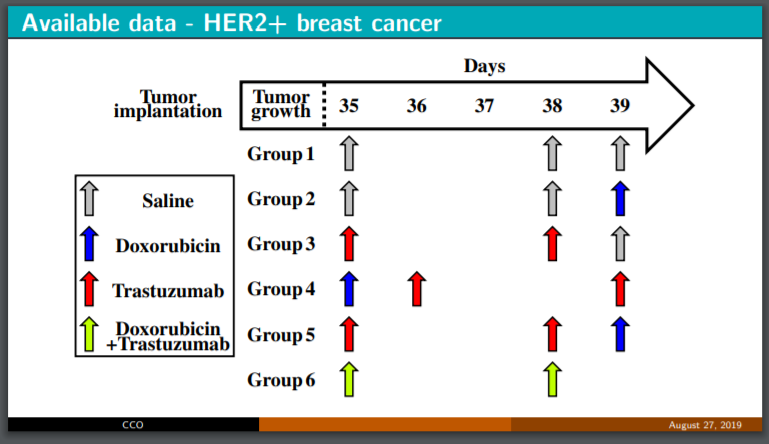

#### exp
dydt = r*T - St*T - Sd*T
#### allee
dydt = r*(T/A-1)*T - St*T - Sd*T
#### logistic
dydt = r*T*(1-T/K) - St*T - Sd*T
#### logistic and allee
dydt = r*T*(T/A-1)*(1-T/K) - St*T - Sd*T
#### model 5
dydt = (r-St)*T*(1-T/K) - Sd*T
#### model 6
dydt = (r-St)*T*(T/A-1)*(1-T/K) - Sd*T
#### model 7 
dydt = (r-Sd)*T*(1-T/K) - St*T
#### model 8 
dydt = (r-Sd)*T*(T/A - 1)*(1-T/K) - St*T
#### model 9
dydt = (r-St-Sd)*T*(1-T/K)
#### model 10
dydt = (r-St-Sd)*T*(T/A-1)*(1-T/K)


### Other growth models for potential investigation, from Skehan et al. 1984


<div>
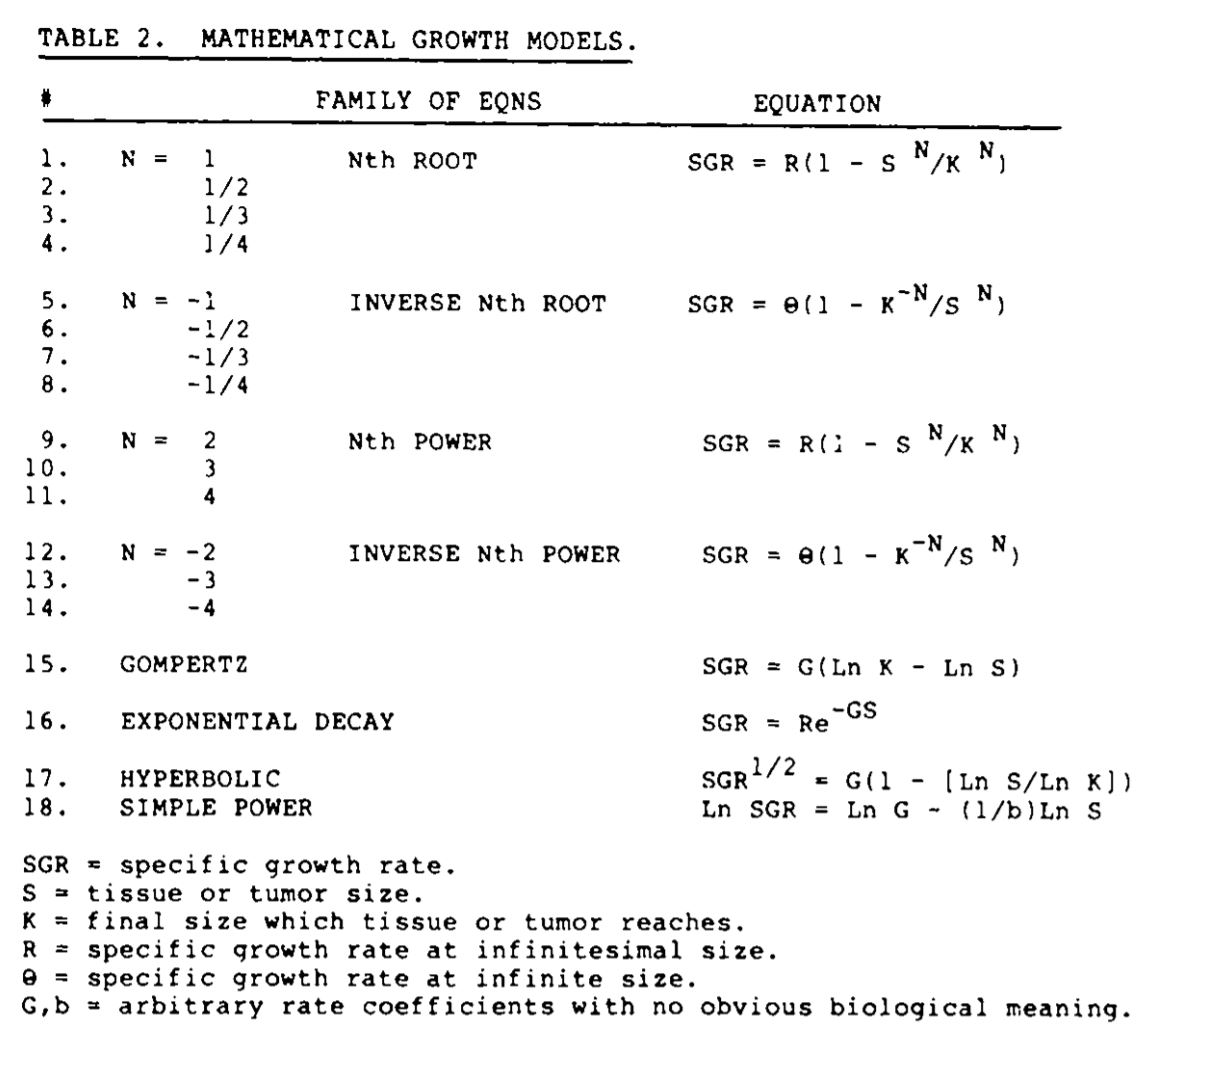
</div>

In [3]:
dirname = os.getcwd()
filename = dirname + '\..\data\\tumor_size_db.csv'
tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()

Day      G1_avg       G1_sd      G2_avg      G2_sd      G3_avg       G3_sd  \
0    7   53.973689   19.464756   27.939597  19.032486   44.872119   20.290405   
1   14   56.730533   34.316923   47.079148  26.709641   59.175717   41.133786   
2   23   90.677211   51.384002   61.140151  31.821015  112.524376   51.204812   
3   29  182.971051   96.268908  127.343047  61.519414  211.247381  127.305794   
4   34  284.888364  147.891820  225.843888  92.229404  346.168185  147.788359   

       G4_avg       G4_sd      G5_avg       G5_sd      G6_avg       G6_sd  
0   38.955318   21.359080   30.988742   17.752230   42.366388   13.069455  
1   39.697439   29.993253   34.640653   25.398323   52.488467   23.978783  
2   75.404253   68.348904   61.905680   33.892752  118.747997   71.618255  
3  217.351729  153.788112  134.994293   65.107710  182.961115  103.520392  
4  388.344451  247.451969  257.324806  123.482982  267.228868  140.192699

In [4]:
ts = np.array(tumor_size_db['Day']).reshape(-1,1)
y = np.array(tumor_size_db['G1_avg']).reshape(-1,1)
ys = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

In [5]:
#set of variables

#fitted
#r, double
#K, double
#A, double
#delta, double
#tau, double

#dependent variables
#St, array of doubles
#Sd, array of doubles

#constants
#ts, array of ints
#T, double
#tt_dox, tuple of ints
#tt_tras, tuple of ints


#booleans per group
#group 1
#r=1, K=1, A=1, St=0, Sd=0
#group 2
#r=1, K=1, A=1, St=0, Sd=1
#group 3
#r=1, K=1, A=1, St=1, Sd=0
#group 4
#r=1, K=1, A=1, St=1, Sd=0
#group 5
#r=1, K=1, A=1, St=1, Sd=1
#group 6
#r=1, K=1, A=1, St=1, Sd=1



In [6]:
def unit(x):
    if x>=0: return 1
    return 0

def get_tt(tuple_treatment_group):
    switcher={
        ('dox',2): [39],
        
        ('tras',3): [35,38],
        
        ('dox',4): [35],
        ('tras',4): [36,39],
        
        ('tras',5): [35,38],
        ('dox',5): [39],
        
        ('tras',6): [35,38],
        ('dox',6): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])
"""
#S = delta*T*exp(-tau(t-tt))unit(t-tt)
def treatment(delta, Ts, tau, ts, treatment_times, ret_t=False):
    S = np.zeros(ts.shape)
    for t in ts:
        if len(treatment_times) != 0:
            T = Ts[t]
            for tt in treatment_times:
                #print(S[t])
                #print(unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)))
                S[t] = S[t] + unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)) #the 0.0001 reflects that treatment was given just after measuremens on treatment days
                #print('S at ' + str(t) + ' is:' + str(S[t]))
    if ret_t: return ts, S.reshape(-1,1)
    return S.reshape(-1,1)


def dox_treatment_by_group(delta, Ts, tau, ts, group):
    treatment_times = get_tt(('dox',group))
    Sd = treatment(delta, Ts, tau, ts, treatment_times)
    return Sd
    

def tras_treatment_by_group(delta, Ts, tau, ts, group):
    treatment_times = get_tt(('tras',group))
    St = treatment(delta, Ts, tau, ts, treatment_times)
    return St

def dox_treatment_all(delta, Ts_all, tau, ts):
    Sd = np.zeros((6, len(ts.ravel())))
    for group in range(6):
        Ts = Ts_all[group]
        Sd[group] = dox_treatment_by_group(delta, Ts, tau, ts, group+1).reshape(1,-1)
    return Sd   
    
def tras_treatment_all(delta, Ts_all, tau, ts):
    St = np.zeros((6, len(ts.ravel())))
    for group in range(6):
        Ts = Ts_all[group]
        St[group] = tras_treatment_by_group(delta, Ts, tau, ts, group+1).reshape(1,-1)
    return St

"""




def treatment_inst(delta, T, tau, t, treatment_times):
    if len(treatment_times) == 0: return 0
    S = 0
    for tt in treatment_times:
        if unit(t-tt-0.0001):
            #S = S + delta*T*np.exp(-tau*(t-tt))  
            S = S + delta*np.exp(-tau*(t-tt)) 
        #S = S + unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)) #the 0.0001 reflects that treatment was given just after measuremens on treatment days
        #if abs(T*np.exp(-tau*(t-tt))).any() > 1000000:
        #    if unit(t-tt-0.0001) > 0: 
        #        print('treatment divergence')
        #        print('t: ' + str(t))
        #        print('tt: ' + str(tt))
        #        print('tau: ' + str(tau))
        #if unit(t-tt-0.0001) > 0:
        if math.isnan(S): 
            print('nan treatment')
            print('tau*(t-tt) ' + str(tau*(t-tt)))
            print('T: ' + str(T))
            print('t: ' + str(t))
            print('tt: ' + str(tt))
            print('tau: ' + str(tau))
        #        print('unit: ' + str(unit(t-tt-0.0001)))
        #        print('delta: ' + str(delta))
        #        print('T: ' + str(T))
        #        print('np.exp: ' + str(np.exp(-tau*(t-tt))))
        #        print('t-tt: ' + str(t-tt))
    return S

def dox_treatment_inst(delta, T, tau, t, group_idx):
    treatment_times = get_tt(('dox',group_idx+1))
    return treatment_inst(delta, T, tau, t, treatment_times)
    
def tras_treatment_inst(delta, T, tau, t, group_idx):
    treatment_times = get_tt(('tras', group_idx+1))
    return treatment_inst(delta, T, tau, t, treatment_times)

def dox_treatment_all_inst(delta, T_all, tau, t):
    Sd = np.zeros((6,))
    for group in range(6):
        T = T_all[group]
        Sd[group] = dox_treatment_inst(delta, T, tau, t, group)
    return Sd

def tras_treatment_all_inst(delta, T_all, tau, t):
    St = np.zeros((6,))
    for group in range(6):
        T = T_all[group]
        St[group] = tras_treatment_inst(delta, T, tau, t, group)
    return St

#### Treatment calculation unit tests

In [7]:



def test_treatment():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = (10,40)
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.show()
    return

def test_treatment_2():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = get_tt(('dox',2))
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.title('G2 Dox')
    plt.show()
    return


def test_treatment_3():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = get_tt(('tras',3))
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.title('G3 Tras')
    plt.show()
    return

def test_all_treatment():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones((6, len(ts.ravel())))
    Ts[1] = np.zeros((1, len(ts.ravel())))
    
    dox = dox_treatment_all(delta, Ts, tau, ts)
    for ii in range(len(dox)):
        row = dox[ii]
        plt.plot(ts, row)
        plt.title('Dox, Group ' + str(ii+1))
        plt.show()
        
    tras = tras_treatment_all(delta, Ts, tau, ts)
    for ii in range(len(tras)):
        row = tras[ii]
        plt.plot(ts, row)
        plt.title('Tras, Group ' + str(ii+1))
        plt.show()
        

def test_all_treatment_inst():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones((6, len(ts.ravel())))
    dox = np.zeros(Ts.shape)
    tras = np.zeros(Ts.shape)
    for t in ts:
        T_all = Ts[:,t]
        dox[:,t] = dox_treatment_all_inst(delta, T_all, tau, t)
        tras[:,t] = tras_treatment_all_inst(delta, T_all, tau, t)
    
    for ii in range(len(dox)):
        plt.plot(ts, dox[ii])
        plt.title('Dox, Group ' + str(ii+1))
        plt.show()
     
    for ii in range(len(tras)):
        plt.plot(ts, tras[ii])
        plt.title('Tras, Group ' + str(ii+1))
        plt.show()
        
    

In [8]:
#test_treatment()
#test_treatment_2()
#test_treatment_3()
#test_all_treatment()
#test_all_treatment_inst()

In [9]:

def rungeKutta(ts, y0, dydt, params): 
    #print('rk begins')
    time_len = len(ts.ravel())
    #ret = np.zeros((6, (len(ts.ravel())))) 
    ret = np.zeros((6, time_len))
    ret[:,0] = y0
    #print('shape of y0 in rk')
    #print(y0.shape)
    y = y0
    #for i in range(1,(len(ts.ravel()))) :
    for i in range(1,time_len):
        y = y.clip(min=0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dydt(t, y, params) 
        k2 = h * dydt(t+0.5*h, y + 0.5 * k1, params) 
        k3 = h * dydt(t+0.5*h, y + 0.5 * k2, params) 
        k4 = h * dydt(t+h, y + k3, params) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        #ret[:,i] = y
        if np.float('-inf') in y: 
            print('divergence in rk')
            print('t0 ' + str(t0))
            print('t ' + str(t))
            print('h ' + str(h))
            print('k1 ' + str(k1))
            print('k2 ' + str(k2))
            print('k3 ' + str(k3))
            print('k4 '  + str(k4))
            print('y ' + str(y))
        ret[:,i] = y.clip(min=0)
        
    #print('rk returns')
    return ret

class growth_model(object):
    def __init__(self, times, y0):
        self._times = times
        self._y0 = y0

    def _simulate(self, params, times):
        #values = odeint(self.dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, self._y0, self.dydt, params)

        return values
    
   
    def get_param(self, param_name, n=50):
        return sum(self.trace[param_name][-n:])/n
    

## Exponential Growth Model

#### exp
dydt = r*T - St*T - Sd*T

In [10]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  ## potential bug fix for slice, don't know if it matters anymore after solving divergence

class exp_growth_model(growth_model):
    
    #def simulate(self, r, K, A, delta, tau, times=None):
    #    if times is None: times = self._times        
    #    return self._simulate([r, K, A, delta, tau], times)
    def simulate(self, r, delta_d, delta_t, tau_d, tau_t, times=None):
        if times is None: times = self._times        
        return self._simulate([r, delta_d, delta_t, tau_d, tau_t], times)
    
    
    
    def dydt(self, t, T, params):  #y being tumor size, T
        T.clip(min=0)    # I don't know if this matters anymore
        
        #if (y.shape != (6,)):
        #    print('y shape wrong in dydt')
        #    print('y is shape: ')
        #    print(y.shape)
        #    return 0
        
        #print('dydt begins')

        r, delta_d, delta_t, tau_d, tau_t = [x for x in params]
        
        #r_vec = np.ones((6,))*r
                       
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)  #concentration is independent of volume
        St = tras_treatment_all_inst(delta_t, T, tau_t, t)
        
        #print(T.shape)
        #print(r_vec.shape)
        #print(Sd.shape)
        #print(St.shape)
        
        #return (r_vec-Sd-St)*T
        #print('t: ' +str(t))
        #print('delta: ' + str(delta))
        #print('tau: ' +str(tau))
        #print('T: ' + str(T))
        #print('r: ' +str(r))
        #print('Sd: ' + str(Sd))
        #print('(r-Sd)*T' + str((r - Sd)*T))
        #print('T' + str(T))
        
        return (r - Sd - St)*T
    
    
    def backward(self, y_obs, sigmas):
        with pm.Model():
            #alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            
            r_lower = 0.03
            r_upper = 0.07
            #K_lower = 1200
            #K_upper = 1500
            #A_lower = 200
            #A_upper = 300
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_t_lower = 0
            delta_t_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 3
            tau_t_lower = 0
            tau_t_upper = 3

            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper) 
            #K = pm.Uniform('K', lower=K_lower, upper=K_upper) # should be passing 0 here
            #A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_t = pm.Uniform('delta_t', lower=delta_t_lower, upper=delta_t_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)          
            tau_t = pm.Uniform('tau_t', lower=tau_t_lower, upper=tau_t_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper) 

            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, delta_d, delta_t, tau_d, tau_t):
                th_states = self.simulate(r, delta_d, delta_t, tau_d, tau_t)
                return th_states
            
            forward = th_forward_model(r, delta_d, delta_t, tau_d, tau_t)
            
            y = pm.Normal('y', mu=forward, sigma = sigmas, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       #'K':np.random.uniform(K_lower, K_upper), 
                       #'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_t':np.random.uniform(delta_t_lower, delta_t_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_t':np.random.uniform(tau_t_lower, tau_t_upper),
                      } for _ in range(n_chains)]
            num_samples = 50
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=50):
        return sum(self.trace[param_name][-n:])/n
    


Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (4 chains in 1 job)
CompoundStep
>Slice: [tau_d]
>Slice: [tau_t]
>Slice: [delta_d]
>Slice: [delta_t]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:34<00:00,  1.75it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


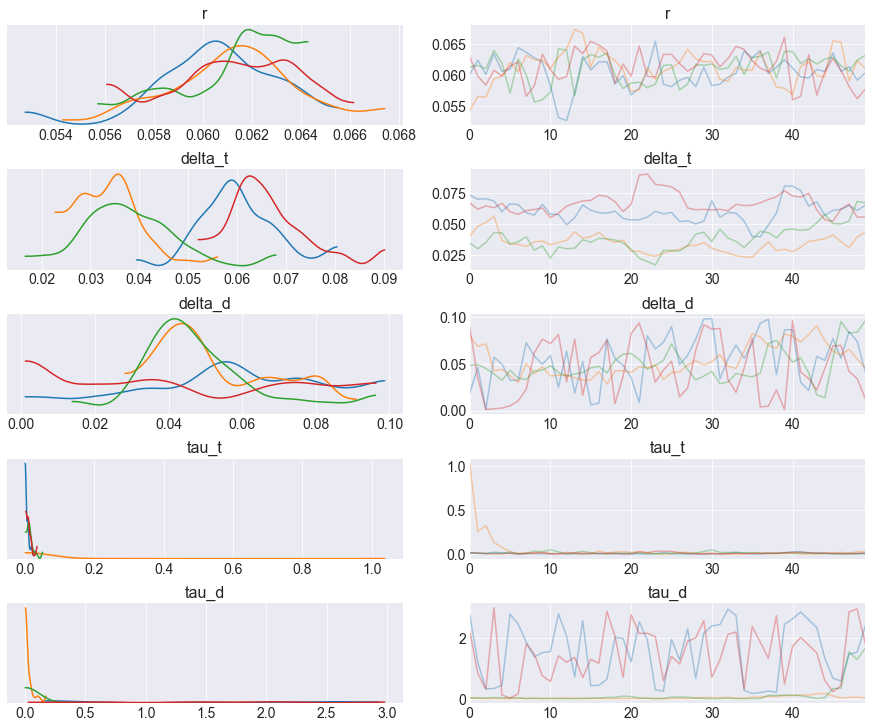

In [11]:
#unit test exp_growth_model
exp2 = exp_growth_model(ts,ys[:,0])
exp2.backward(ys,sigmas)



delta_d 0.04476931735314994
delta_t 0.06622741667378729
tau_d 1.474305225009823
tau_t 0.011196557813340134


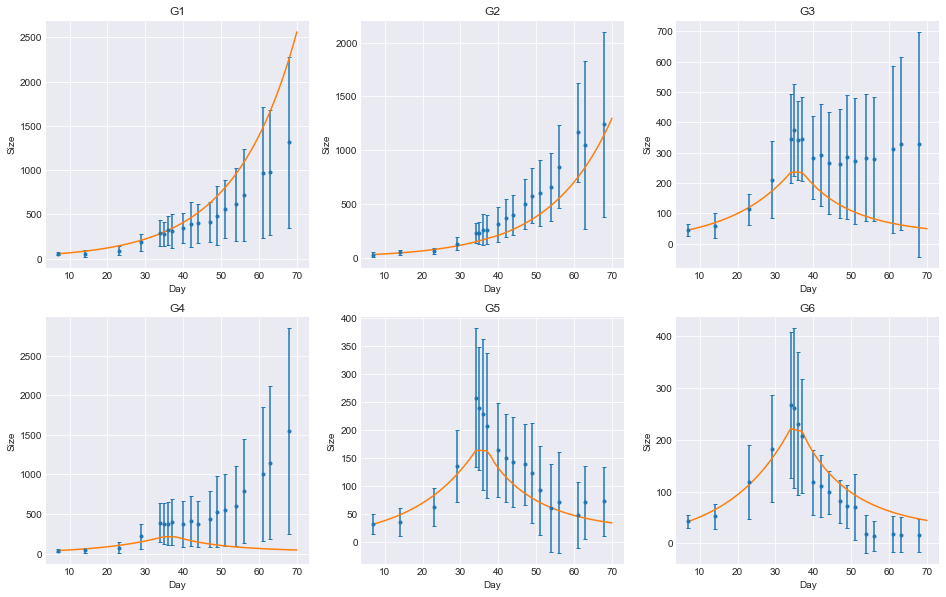

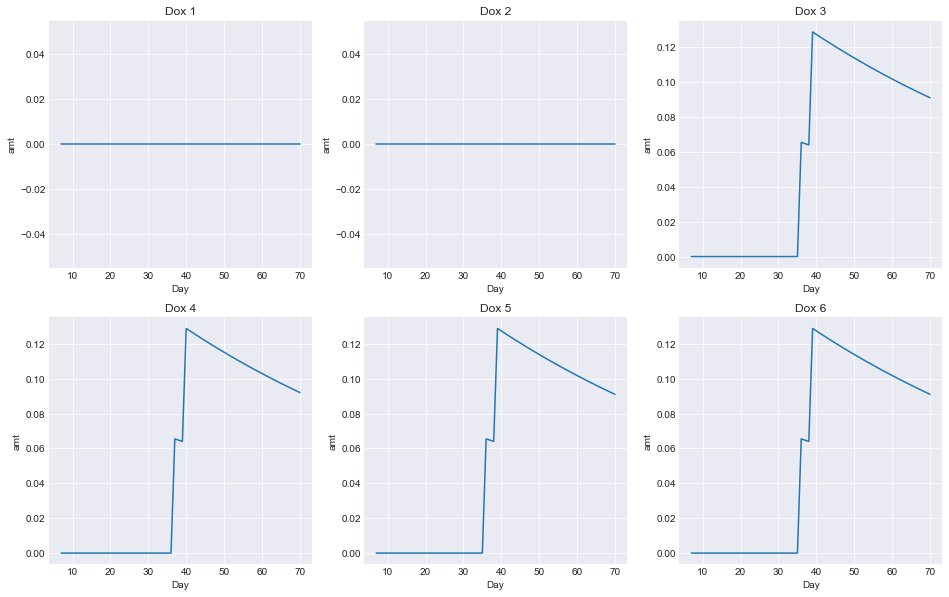

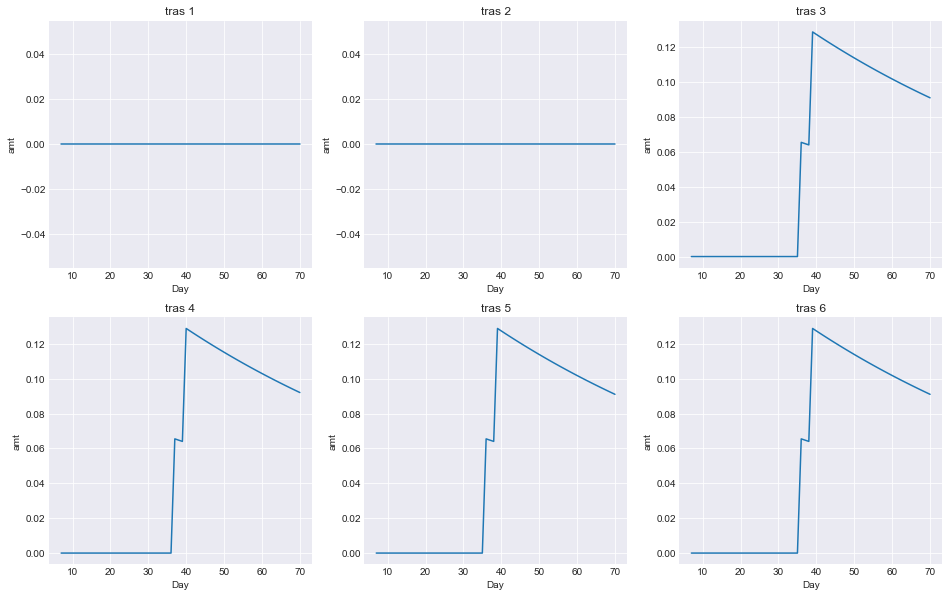

In [15]:
sim_times = np.linspace(7,70,70-7+1) #it's important that we begin the simulation at the same point that was started i.e. 7 days in was the y0
#Y_sim = exp2.simulate(exp1.get_param('alpha'),sim_times)

r = exp2.get_param('r')
#K = exp2.get_param('K')
#A = exp2.get_param('A')
delta_d = exp2.get_param('delta_d')
print('delta_d ' + str(delta_d))
delta_t = exp2.get_param('delta_t')
print('delta_t ' + str(delta_t))

tau_d= exp2.get_param('tau_d')
print('tau_d ' + str(tau_d))
tau_t= exp2.get_param('tau_t')
print('tau_t ' + str(tau_t))


#Y_sim = exp2.simulate(r, K, A, delta, tau, sim_times)
Y_sim = exp2.simulate(r, delta_d, delta_t, tau_d, tau_t, sim_times)

dox = np.zeros((6,len(sim_times.ravel())))
tras = dox
for ii in range(len(sim_times)):
    Y = Y_sim[:,ii]
    t = sim_times[ii]
    dox[:,ii] = dox_treatment_all_inst(delta_d, Y, tau_d, t)
    tras[:,ii] = tras_treatment_all_inst(delta_t, Y, tau_t, t)

#print(Y_sim)
#print(dox)
#print(tras)
#plot the exponential model vs the groups

plt.figure(figsize=[16,10])
for ii in range(6):
    plt.subplot(2,3,ii+1)
    #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
    plt.errorbar(tumor_size_db['Day'], ys[ii], sigmas[ii],fmt='.',capsize=2)
    plt.plot(sim_times, Y_sim[ii])
    plt.title('G' + str(ii+1))
    plt.xlabel('Day')
    plt.ylabel('Size')
plt.show()

def graph_sim(sim_times, Y_sim):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.errorbar(tumor_size_db['Day'], ys[ii], sigmas[ii],fmt='.',capsize=2)
        plt.plot(sim_times, Y_sim[ii])
        plt.title('G' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('Size')
    plt.show()
    

plt.figure(figsize=[16,10])
for ii in range(6):
    plt.subplot(2,3,ii+1)
    #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
    plt.plot(sim_times, dox[ii])
    plt.title('Dox ' + str(ii+1))
    plt.xlabel('Day')
    plt.ylabel('amt')
plt.show()

def graph_dox(sim_times, dox):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.plot(sim_times, dox[ii])
        plt.title('Dox ' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()
    

plt.figure(figsize=[16,10])
for ii in range(6):
    plt.subplot(2,3,ii+1)
    #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
    plt.plot(sim_times, tras[ii])
    plt.title('tras ' + str(ii+1))
    plt.xlabel('Day')
    plt.ylabel('amt')
plt.show()

def graph_tras(sim_times, tras):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.plot(sim_times, tras[ii])
        plt.title('tras ' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()




## better convergence for dydt = r*T -Sd - St (Sd, St dependent on T)

r_lower = 0.052
r_upper = 0.066
delta_lower = 0.05
delta_upper = 0.275
tau_lower = 0.01
tau_upper = 0.25

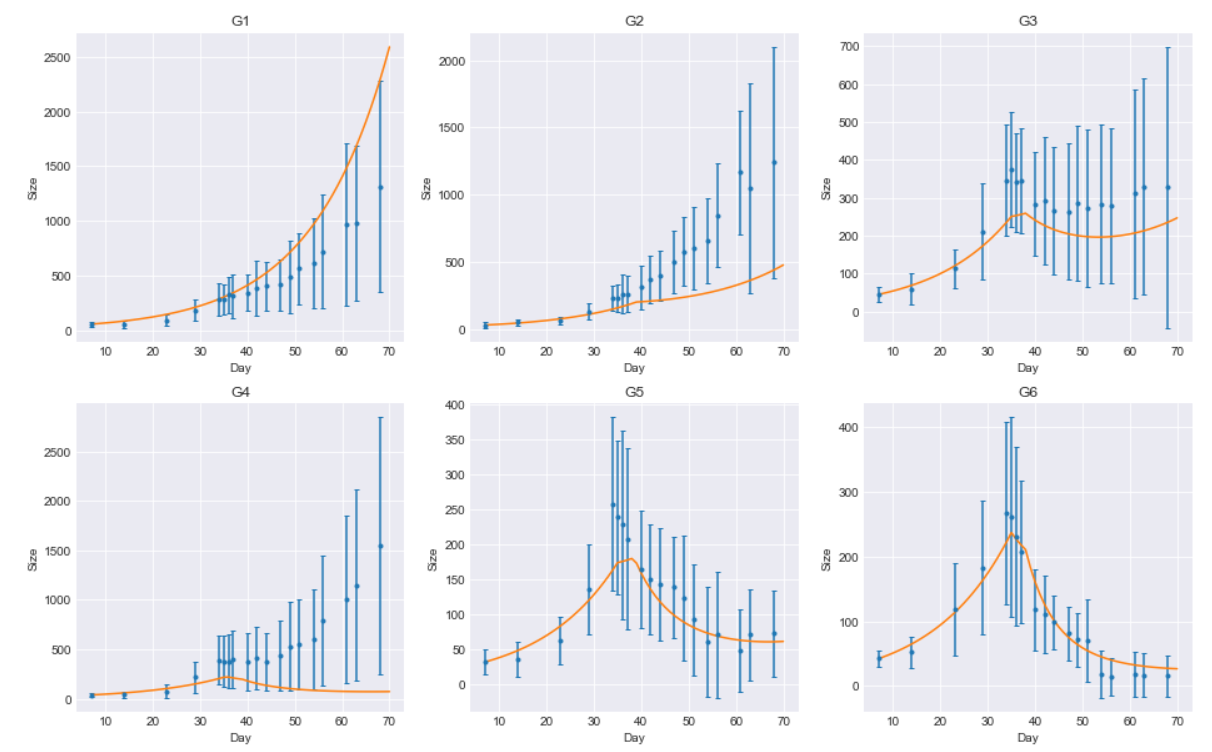

## Allee growth model



#### allee
dydt = r*(T/A-1)*T - St*T - Sd*T



In [17]:

class allee_growth_model(growth_model):  
    
    def simulate(self, r, A, delta_d, delta_t, tau_d, tau_t, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta_d, delta_t, tau_d, tau_t], times)
    
    def dydt(self, t, T, params):
        r, A, delta_d, delta_t, tau_d, tau_t = [x for x in params]             
        Sd = dox_treatment_all_inst(delta_d, T, tau_d, t)
        St = tras_treatment_all_inst(delta_t, T, tau_t, t)
        return  (r*(T/A-1) - St - Sd)*T
    
    def backward(self, y_obs, sigmas):
        with pm.Model():
            #alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            
            r_lower = 0.03
            r_upper = 0.07
            #K_lower = 1200
            #K_upper = 1500
            A_lower = 200
            A_upper = 300
            delta_d_lower = 0
            delta_d_upper = 0.1
            delta_t_lower = 0
            delta_t_upper = 0.1
            tau_d_lower = 0
            tau_d_upper = 3
            tau_t_lower = 0
            tau_t_upper = 3

            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper) 
            #K = pm.Uniform('K', lower=K_lower, upper=K_upper) # should be passing 0 here
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta_t = pm.Uniform('delta_t', lower=delta_t_lower, upper=delta_t_upper)
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)          
            tau_t = pm.Uniform('tau_t', lower=tau_t_lower, upper=tau_t_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper) 

            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta_d, delta_t, tau_d, tau_t):
                th_states = self.simulate(r, A, delta_d, delta_t, tau_d, tau_t)
                return th_states
            
            forward = th_forward_model(r, A, delta_d, delta_t, tau_d, tau_t)
            
            y = pm.Normal('y', mu=forward, sigma = sigmas, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       #'K':np.random.uniform(K_lower, K_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'delta_t':np.random.uniform(delta_t_lower, delta_t_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_t':np.random.uniform(tau_t_lower, tau_t_upper),
                      } for _ in range(n_chains)]
            num_samples = 50
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def get_param(self, param_name, n=50):
        return sum(self.trace[param_name][-n:])/n

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (4 chains in 1 job)
CompoundStep
>Slice: [tau_d]
>Slice: [tau_t]
>Slice: [delta_d]
>Slice: [delta_t]
>Slice: [A]
>Slice: [r]
100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.31it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


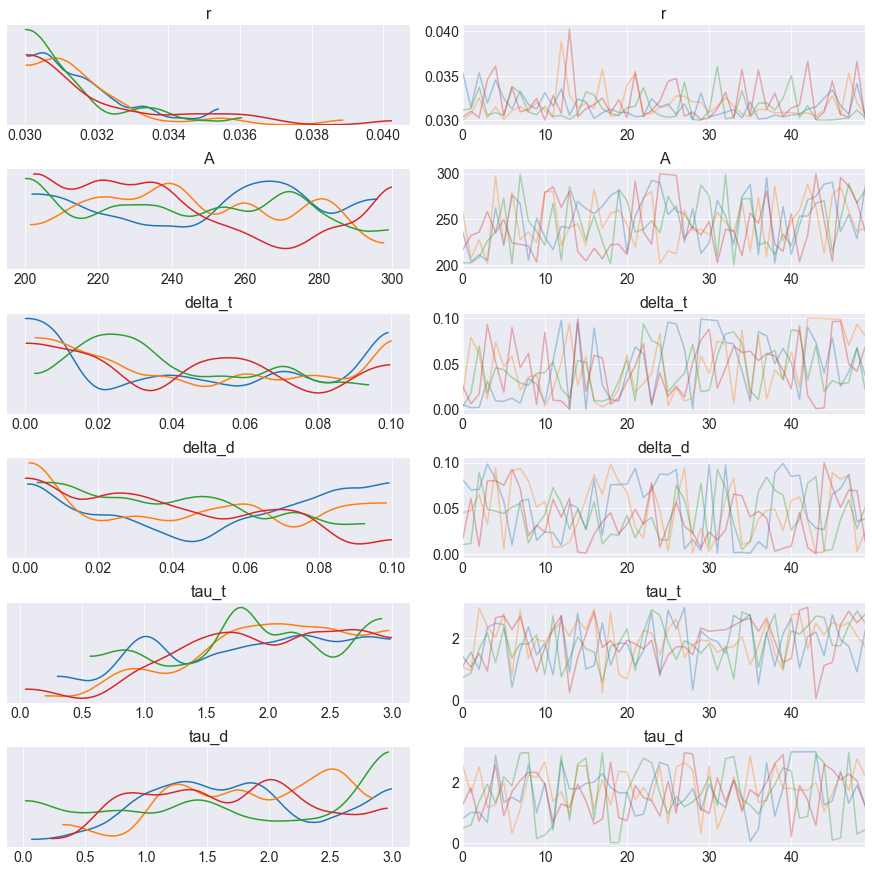

In [18]:
allee2 = allee_growth_model(ts,ys[:,0])
allee2.backward(ys,sigmas)


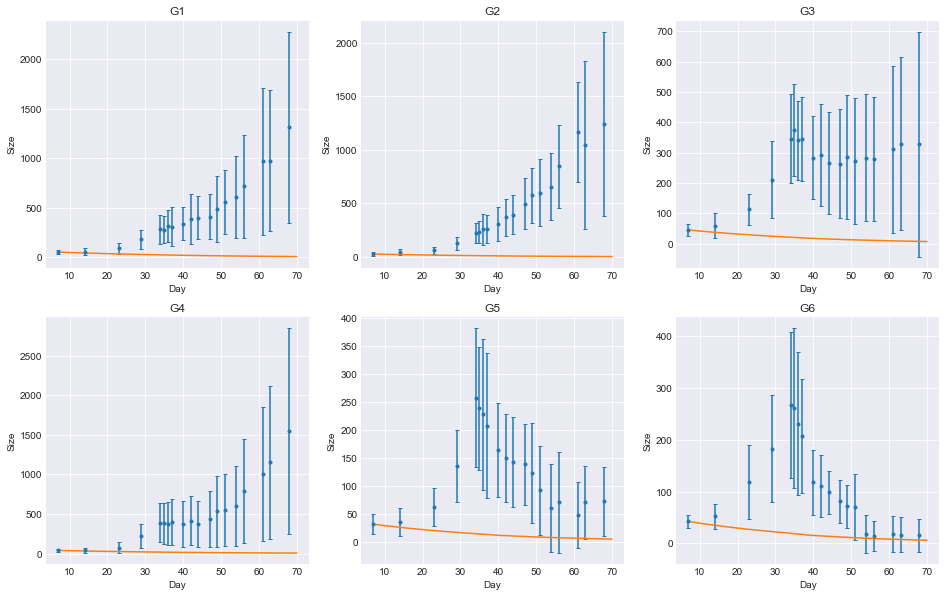

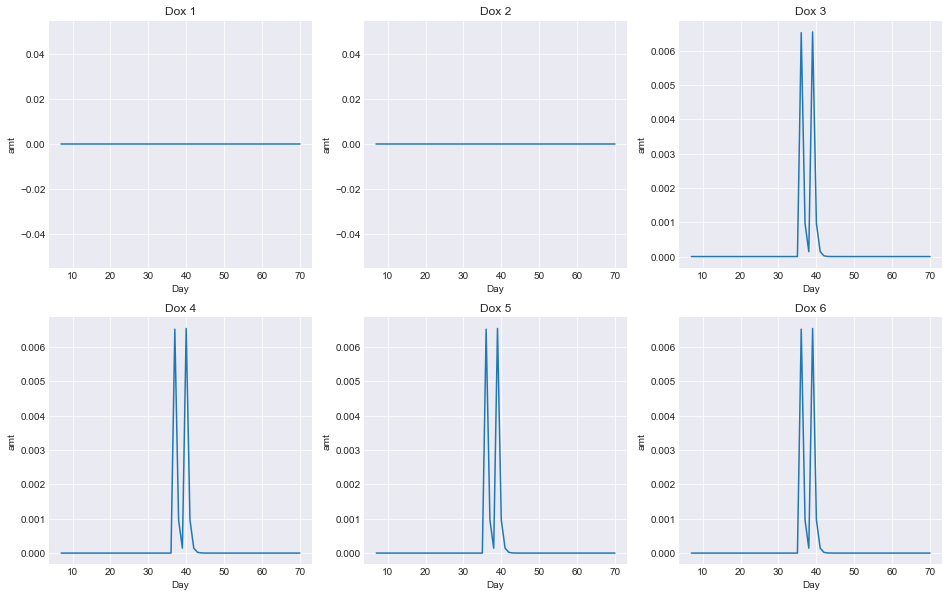

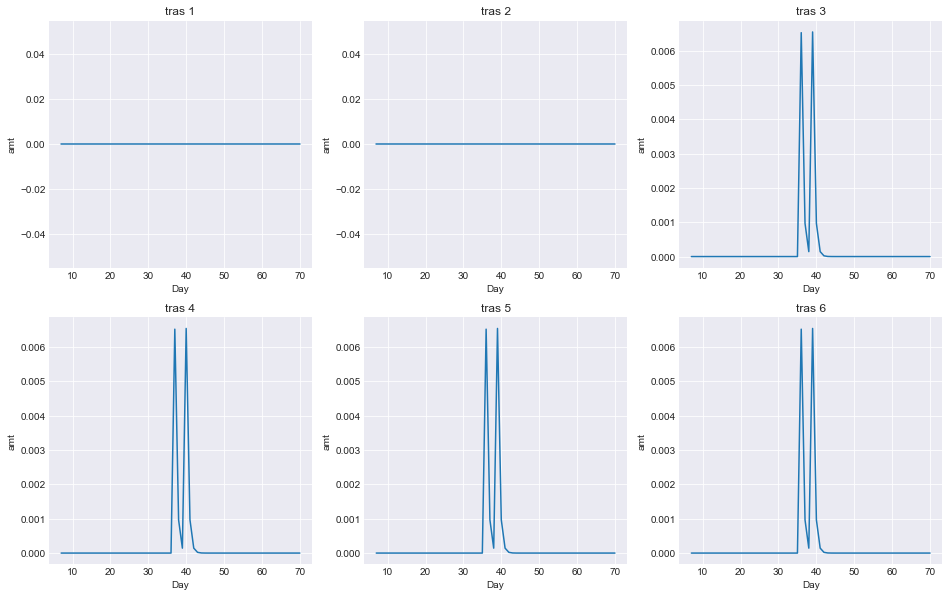

In [20]:
sim_times = np.linspace(7,70,70-7+1)

r = allee2.get_param('r')
A = allee2.get_param('A')
delta_d = allee2.get_param('delta_d')
#print('delta_d ' + str(delta_d))
delta_t = allee2.get_param('delta_t')
#print('delta_t ' + str(delta_t))

tau_d= allee2.get_param('tau_d')
#print('tau_d ' + str(tau_d))
tau_t= allee2.get_param('tau_t')
#print('tau_t ' + str(tau_t))

Y_sim = allee2.simulate(r, A, delta_d, delta_t, tau_d, tau_t, sim_times)

dox = np.zeros((6,len(sim_times.ravel())))
tras = dox
for ii in range(len(sim_times)):
    Y = Y_sim[:,ii]
    t = sim_times[ii]
    dox[:,ii] = dox_treatment_all_inst(delta_d, Y, tau_d, t)
    tras[:,ii] = tras_treatment_all_inst(delta_t, Y, tau_t, t)


graph_sim(sim_times, Y_sim)
graph_dox(sim_times, dox)
graph_tras(sim_times, tras)



## Logistic Growth Model

In [ ]:
#### logistic
dydt = (r*(1-T/K) - St - Sd)*T


In [ ]:

class allee_growth_model(growth_model):
    def simulate(self, r, A, delta, tau, times=None):
        if times is None: times = self._times        
        return self._simulate([r, A, delta, tau], times)
    
    def dydt(self, t, T, params):
        r, A, delta, tau = [x for x in params]             
        Sd = dox_treatment_all_inst(delta, T, tau, t)
        St = tras_treatment_all_inst(delta, T, tau, t)
        return  (r*(T/A-1) - St - Sd)*T
    
    def backward(self, y_obs, sigmas):
        with pm.Model():
            #alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            
            r_lower = 0.052
            r_upper = 0.066
            A_lower = 200
            A_upper = 300
            delta_lower = 0.05
            delta_upper = 0.275
            tau_lower = 0.01
            tau_upper = 0.25
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper) 
            A = pm.Uniform('A', lower=A_lower, upper=A_upper)
            delta = pm.Uniform('delta', lower=delta_lower, upper=delta_upper)
            tau = pm.Uniform('tau', lower=tau_lower, upper=tau_upper)
            
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, A, delta, tau):
                th_states = self.simulate(r, A, delta, tau)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
                #print(th_states.shape)
                return th_states
            
            #forward = th_forward_model(r, K, A, delta, tau)
            forward = th_forward_model(r, A, delta, tau)
            
            
            y = pm.Normal('y', mu=forward, sigma = sigmas, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       #'K':np.random.uniform(K_lower, K_upper), 
                       'A':np.random.uniform(A_lower, A_upper),
                       'delta':np.random.uniform(delta_lower, delta_upper),
                       'tau':np.random.uniform(tau_lower, tau_upper),
                      } for _ in range(n_chains)]
            num_samples = 500
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=int(num_samples/5)):
        return sum(self.trace[param_name][-n:])/n

#### logistic and allee
dydt = r*T*(T/A-1)*(1-T/K) - St*T - Sd*T
#### model 5
dydt = (r-St)*T*(1-T/K) - Sd*T
#### model 6
dydt = (r-St)*T*(T/A-1)*(1-T/K) - Sd*T
#### model 7 
dydt = (r-Sd)*T*(1-T/K) - St*T
#### model 8 
dydt = (r-Sd)*T*(T/A - 1)*(1-T/K) - St*T
#### model 9
dydt = (r-St-Sd)*T*(1-T/K)
#### model 10
dydt = (r-St-Sd)*T*(T/A-1)*(1-T/K)